### Instalacja bibliotek (pip zadziała z poziomu Jupytera, jeśli korzystasz z innej dystrybucji Pythona, użyj CMD/Terminala)

In [1]:
# pip install pydub librosa

In [60]:
from pydub import AudioSegment
import librosa
import numpy as np

# Podaj lokalną ścieżkę do ffmpeg - w przypadku braku kodeka w systemie!
ffmpeg_path = "ffmpeg-6.1"
AudioSegment.converter = ffmpeg_path

# Funkcja do ekstrakcji cech z pliku audio z określoną długością
def extract_mfcc_fixed_length(audio_file, target_length_seconds=5.0):
    audio, sr = librosa.load(audio_file, sr=None)

    # Określ docelową długość sygnału w próbkach
    target_length_samples = int(target_length_seconds * sr)

    # Jeśli sygnał jest dłuższy niż docelowa długość, obetnij go
    if len(audio) > target_length_samples:
        audio = audio[:target_length_samples]

    # Jeśli sygnał jest krótszy, uzupełnij zerami do docelowej długości
    else:
        audio = np.pad(audio, (0, target_length_samples - len(audio)))
    
    # Ekstrakcja cech MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return mfccs.T  # Transponujemy, aby mieć cechy na osi czasu

# Wczytaj trzy pliki mp3
file1 = "sanah.mp3"
file2 = "holownia.mp3"
file3 = "kizo.mp3"
test_file1 = "test.mp3"
test_file2 = "test2.mp3"
test_file3 = "kizo.mp3"

# Ekstrakcja cech dźwiękowych (MFCCs) z zahardcodowaną minimalną długością na 5 sekund
features1 = extract_mfcc_fixed_length(file1)
features2 = extract_mfcc_fixed_length(file2)
features3 = extract_mfcc_fixed_length(file3)
test_features1 = extract_mfcc_fixed_length(test_file1)
test_features2 = extract_mfcc_fixed_length(test_file2)
test_features3 = extract_mfcc_fixed_length(test_file3)

print(features1)
print(features1.shape)
print(features3 == test_features3)

[[-6.9897839e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-6.9897839e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-6.9897839e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-3.2580405e+02  1.2277699e+02  2.2308037e-01 ... -1.2926807e+01
   1.4877205e+00 -6.8166027e+00]
 [-3.3156384e+02  1.2179018e+02 -2.3795836e+00 ... -9.7075596e+00
   4.8439941e+00 -3.9417415e+00]
 [-3.2910959e+02  1.1763646e+02 -8.0111790e+00 ... -2.9047325e+00
  -3.3123302e+00 -3.2559991e+00]]
(469, 13)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


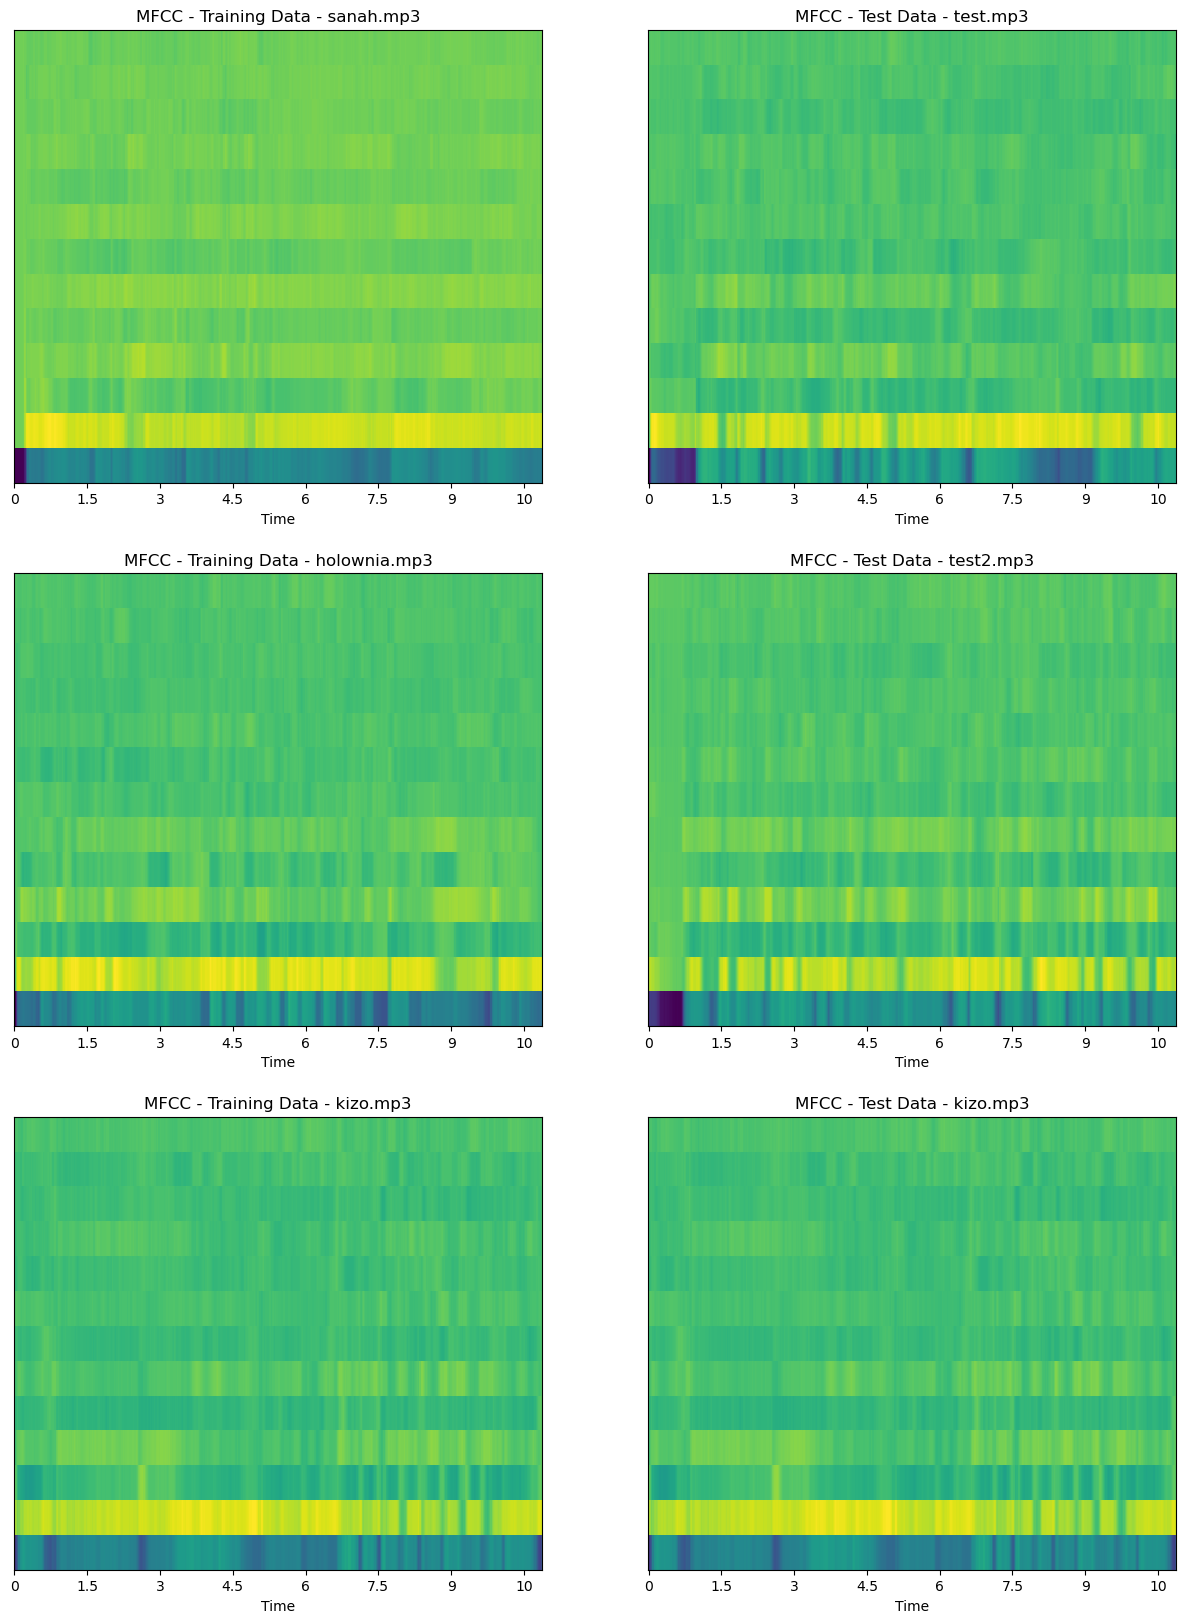

In [61]:
# Wizualizacja krzywych MFCC

import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))

# Pierwsza kolumna - dane treningowe
plt.subplot(3, 2, 1)
librosa.display.specshow(features1.T, x_axis='time', cmap='viridis')
plt.title('MFCC - Training Data - ' + file1)

plt.subplot(3, 2, 3)
librosa.display.specshow(features2.T, x_axis='time', cmap='viridis')
plt.title('MFCC - Training Data - ' + file2)

plt.subplot(3, 2, 5)
librosa.display.specshow(features3.T, x_axis='time', cmap='viridis')
plt.title('MFCC - Training Data - ' + file3)

# Druga kolumna - dane testowe
plt.subplot(3, 2, 2)
librosa.display.specshow(test_features1.T, x_axis='time', cmap='viridis')
plt.title('MFCC - Test Data - ' + test_file1)

plt.subplot(3, 2, 4)
librosa.display.specshow(test_features2.T, x_axis='time', cmap='viridis')
plt.title('MFCC - Test Data - ' + test_file2)

plt.subplot(3, 2, 6)
librosa.display.specshow(test_features3.T, x_axis='time', cmap='viridis')
plt.title('MFCC - Test Data - ' + test_file3)

plt.show()

In [62]:
from sklearn.preprocessing import MinMaxScaler

# Normalizacja danych treningowych
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(np.vstack([features1, features2, features3]))

print(X_train_scaled)

[[0.         0.11630561 0.5948166  ... 0.8207549  0.7037072  0.5603661 ]
 [0.         0.11630561 0.5948166  ... 0.8207549  0.7037072  0.5603661 ]
 [0.         0.11630561 0.5948166  ... 0.8207549  0.7037072  0.5603661 ]
 ...
 [0.5496973  0.80879486 0.7108771  ... 0.48916936 0.49950278 0.62824667]
 [0.53046155 0.7979421  0.7347544  ... 0.53195393 0.5446793  0.57811   ]
 [0.60103446 0.74548244 0.6947845  ... 0.71673036 0.68149763 0.56462604]]


In [63]:
# Te dwie linijki - dla pozbycia się warninga przy imporcie GaussianMixture
import os
os.environ["OMP_NUM_THREADS"] = '1'

from sklearn.mixture import GaussianMixture

# Dopasuj model GMM
num_speakers = 3  # liczba próbek dźwięku
gmm = GaussianMixture(n_components=num_speakers, covariance_type='full', random_state=6)
gmm.fit(X_train_scaled)

GaussianMixture(n_components=3, random_state=6)

In [64]:
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

means
# covariances
# weights

array([[0.78156742, 0.75961663, 0.3637526 , 0.51757636, 0.60569226,
        0.46965526, 0.62444528, 0.36278207, 0.53294192, 0.32898916,
        0.63589946, 0.55901565, 0.50934322],
       [0.68080557, 0.57022653, 0.45368483, 0.48857097, 0.5070275 ,
        0.5537507 , 0.47804363, 0.6716598 , 0.45211934, 0.5638465 ,
        0.66349538, 0.68719275, 0.4698551 ],
       [0.84649827, 0.68725338, 0.3644612 , 0.44394071, 0.32387736,
        0.32235048, 0.38224008, 0.47113855, 0.38490512, 0.45109442,
        0.50485342, 0.39752292, 0.58402018]])

In [67]:
# Normalizacja danych testowych
test_features1_scaled = scaler.transform(test_features1)
test_features2_scaled = scaler.transform(test_features2)
test_features3_scaled = scaler.transform(test_features3)

# Przewidywanie klas dla danych testowych
predicted_label1 = gmm.predict(test_features1_scaled)
predicted_label2 = gmm.predict(test_features2_scaled)
predicted_label3 = gmm.predict(test_features3_scaled)

print(predicted_label1)

[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 2 1
 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 0 0 1 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1]


In [50]:
# Odpowiadamy na pytanie: W jakim stopniu dany głos testowy jest podobny do określonego głosu ze zbioru treningowego
# [Czyli musimy postawić hipotezę z góry]

#Etykiety dla danych treningowych (dane "idealne")
# głos 1 [Sanah] -> [0 0 0 0 0 ...]
# głos 2 [Holownia] -> [1 1 1 1 1 ...]
# głos 3 [Kizo] -> [2 2 2 2 2 ...]

# Oczekiwane etykiety dla danych testowych
expected_label1 = 2 * np.ones(len(predicted_label3))  # Sprawdzamy, czy Test [inny Kizo] == Kizo
expected_label2 = np.ones(len(predicted_label2))   # Sprawdzamy czy Test2 [Peja] == Hołownia
expected_label3 = 2 * np.ones(len(predicted_label3))  # Sprawdzamy czy Kizo == Kizo (ta sama próbka)

# Porównanie przewidywanych i oczekiwanych etykiet
accuracy1 = np.mean(predicted_label1 == expected_label1)
accuracy2 = np.mean(predicted_label2 == expected_label2)
accuracy3 = np.mean(predicted_label3 == expected_label3)

print(f'Accuracy for test_file1: {accuracy1 * 100}%')
print(f'Accuracy for test_file2: {accuracy2 * 100}%')
print(f'Accuracy for test_file3: {accuracy3 * 100}%')


Accuracy for test_file1: 12.79317697228145%
Accuracy for test_file2: 88.27292110874201%
Accuracy for test_file3: 71.42857142857143%


In [68]:
# Wnioski: Metoda GMM nie daje tu idealnych rezultatów i przy tak małej liczbie danych może nas wprowadzić w błąd.
# Mamy tylko kilkusekundowe fragmenty trzech nagrań, na których nasz model mógł się nauczyć.
# Głos słyszalny ludzkim uchem to nie to samo co sygnał przetwarzany cyfrowo. Sygnał dźwiękowy jest też zmienny w czasie, co nie ułatwia analizy.
# Dla ulepszenia modelowania, należałoby zastosować na przykład: większą liczbę danych, oczyszczenie danych z szumów (np. muzyka, dźwięki tła) oraz wybrać cechy dźwięku, które najlepiej nadają się do odróżniania barwy głosu (nasze modelowanie przeprowadzaliśmy na całej 13-wymiarowej przestrzeni cech MFCC)